In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'])

In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_b.shape

(60, 2)

In [5]:
sales_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_b['Sales'].sum()

70016882

In [7]:
sales_b = sales_b.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_b.head(5)

ds        y
0 2019-01-01   494357
1 2019-02-01   837207
2 2019-03-01  1278271
3 2019-04-01   675985
4 2019-05-01   757687

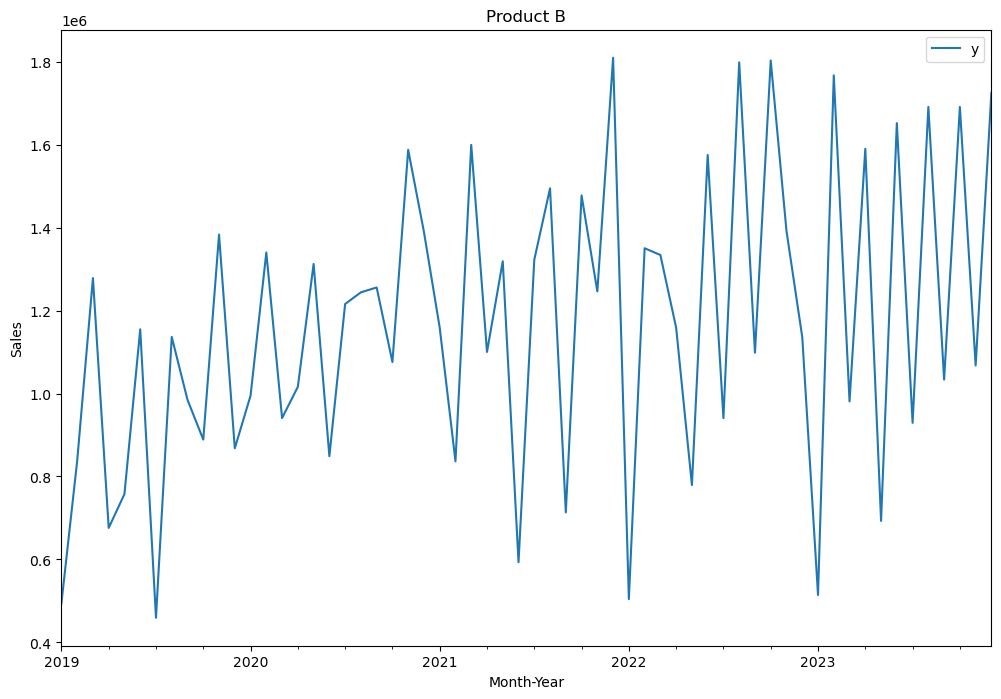

In [8]:
ax = sales_b.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product B')
plt.show()

In [9]:
train= sales_b[:54]
test=sales_b[54:]

# Hyperparameter Tuning

In [10]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:42:45 - cmdstanpy - INFO - Chain [1] start processing
16:42:46 - cmdstanpy - INFO - Chain [1] done processing
16:42:49 - cmdstanpy - INFO - Chain [1] start processing
16:42:49 - cmdstanpy - INFO - Chain [1] done processing
16:42:54 - cmdstanpy - INFO - Chain [1] start processing
16:42:54 - cmdstanpy - INFO - Chain [1] done processing
16:42:58 - cmdstanpy - INFO - Chain [1] start processing
16:42:58 - cmdstanpy - INFO - Chain [1] done processing
16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:03 - cmdstanpy - INFO - Chain [1] done processing
16:43:28 - cmdstanpy - INFO - Chain [1] start processing
16:43:32 - cmdstanpy - INFO - Chain [1] done processing
16:43:36 - cmdstanpy - INFO - Chain [1] start processing
16:43:37 - cmdstanpy - INFO - Chain [1] done processing
16:43:40 - cmdstanpy - INFO - Chain [1] start processing
16:43:40 - cmdstanpy - INFO - Chain [1] done processing
16:43:44 - cmdstanpy - INFO - Chain [1] start processing
16:43:44 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   418227.922347  
1   424227.250907  
2   411513.582660  
3   427124.190979  
4   392044.055963  
.. 

In [11]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
46                    0.200                    10.00         additive   
6                     0.001                     3.00         additive   
9                     0.001                     5.00   multiplicative   
34                    0.100                    10.00         additive   
22                    0.010                    10.00         additive   
..                      ...                      ...              ...   
39                    0.200                     0.10   multiplicative   
1                     0.001                     0.01   multiplicative   
3                     0.001                     0.10   multiplicative   
60                    0.500                     0.01         additive   
61                    0.500                     0.01   multiplicative   

             rmse  
46  384069.948072  
6   384769.677186  
9   384843.507388  
34  385233.627369  
22  385621.720926  
..            ...  
39  424133.098212  
1   424227.250907  
3   427124.190979  
60  442317.624402  
61  444196.491594  

[72 rows x 4 columns]

In [12]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


In [13]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.200, seasonality_prior_scale=10.00, seasonality_mode = 'additive',
                interval_width=0.95)

In [14]:
model.fit(train)

16:48:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:58 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
len(test)

6

In [16]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [17]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [18]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [19]:
forecasted_df

ds          yhat    yhat_lower    yhat_upper
54 2023-07-01  9.004149e+05  4.347072e+05  1.347898e+06
55 2023-08-01  1.732672e+06  1.295962e+06  2.179772e+06
56 2023-09-01  1.268215e+06  8.729227e+05  1.726369e+06
57 2023-10-01  1.581823e+06  1.105154e+06  2.028788e+06
58 2023-11-01  1.612990e+06  1.212355e+06  2.052742e+06
59 2023-12-01  1.222684e+06  7.933099e+05  1.663014e+06

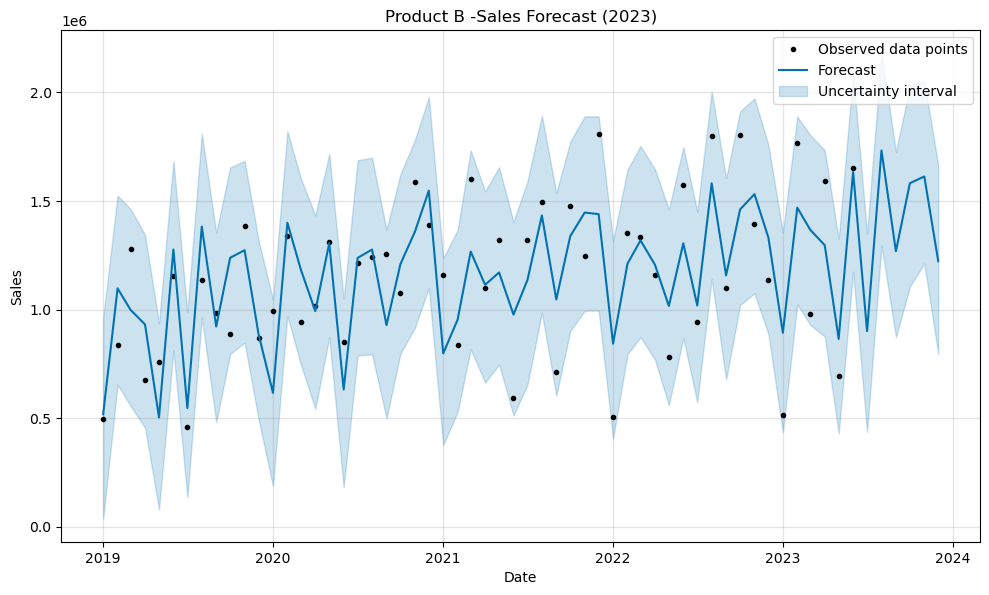

In [20]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

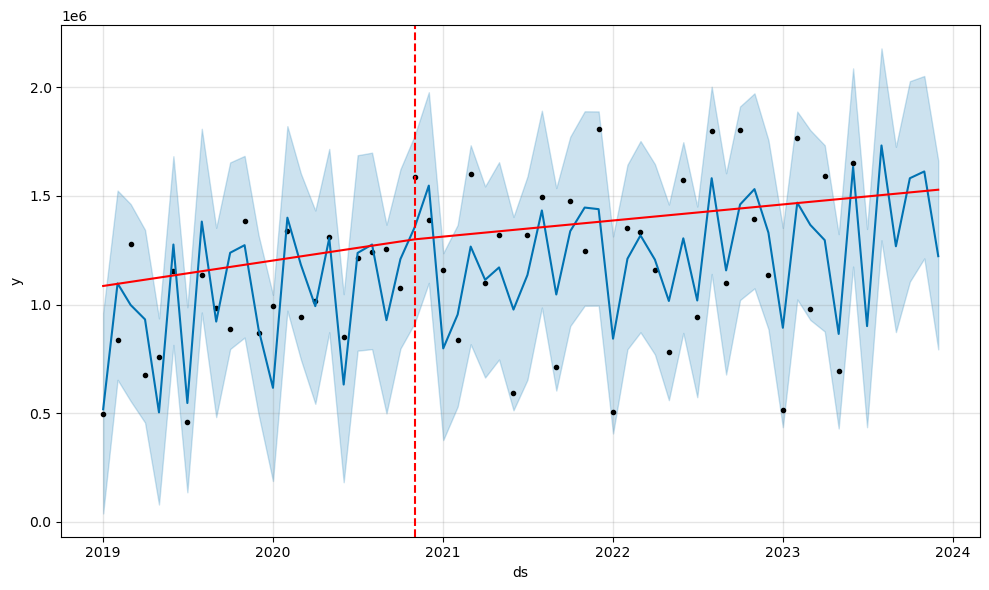

In [21]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

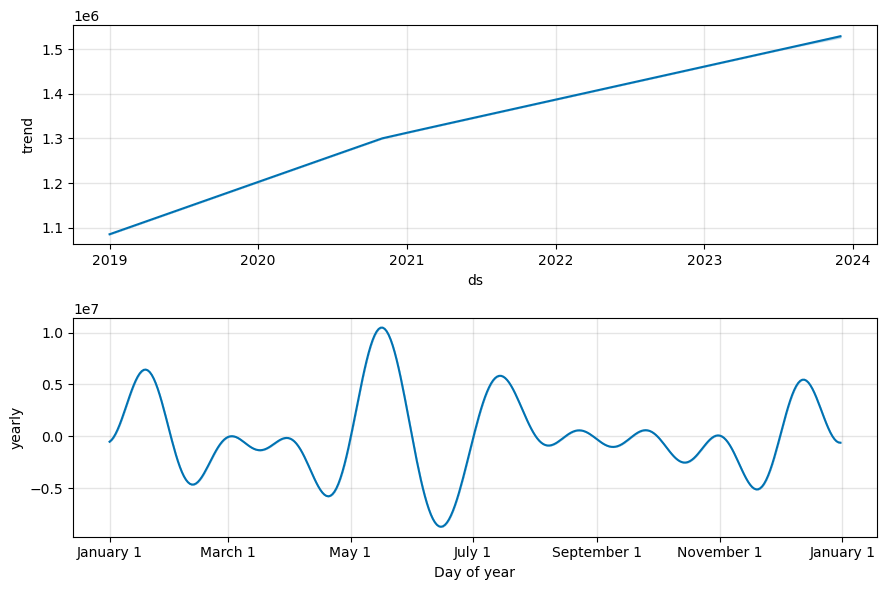

In [22]:
fig2 = model.plot_components(forecast)

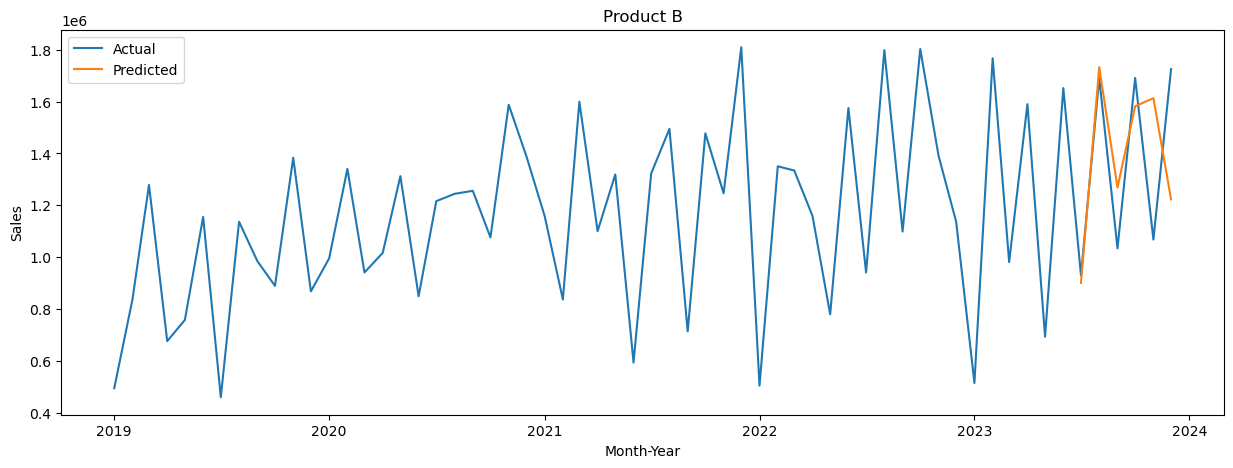

In [23]:
# Reset index of sales_b DataFrame
sales_b_reset_index = sales_b.reset_index()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(sales_b_reset_index['ds'], sales_b_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product B')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [24]:
#model evaluation

In [25]:
pred=forecasted_df['yhat']
test_df=test['y']

In [26]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 243667.635
MAPE - FB PROPHET: 0.192
MSE - FB PROPHET: 103204188497.185
RMSE - FB PROPHET: 321254.087


In [27]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [28]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [29]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0   24 days  2.874876e+11  536178.713913  494786.929533  0.804369  0.804369   
1   25 days  2.543702e+11  504351.289839  415548.376550  0.764366  0.764366   
2   29 days  1.413460e+11  375960.062566  322675.623165  0.570173  0.570173   
3   51 days  1.605153e+11  400643.654070  375249.689617  0.579787  0.579787   
4   55 days  4.135796e+10  203366.553976  200426.416198  0.140033  0.140033   
5   56 days  5.606258e+10  236775.373430  228397.560030  0.142314  0.142314   
6   60 days  1.097681e+11  331312.735112  329094.978078  0.184804  0.184804   
7   82 days  1.893145e+11  435102.914258  430498.294343  0.449906  0.449906   
8   83 days  1.594987e+11  399372.895901  384043.198916  0.448831  0.448831   
9   87 days  4.265248e+10  206524.756696  187175.814133  0.148346  0.148346   
10  88 days  2.175502e+11  466422.719213  375954.739715  0.377784  0.377784   
11 112 days  3.030873e+11  550533.625825  538758.453449  0.476304  0.476304   
12 114 days  9.067991e+10  301131.055121  221502.450997  0.151544  0.151544   
13 117 days  1.140421e+11  337701.265751  247380.988199  0.139912  0.139912   
14 119 days  2.347239e+11  484483.099945  484430.054710  0.286960  0.286960   
15 143 days  1.707414e+11  413208.686193  403765.635495  0.281360  0.281360   
16 144 days  1.862396e+11  431554.870990  419053.258411  0.461780  0.461780   
17 148 days  1.573281e+11  396646.109882  363544.701370  0.408637  0.408637   
18 149 days  6.827498e+10  261294.805976  256210.378971  0.295513  0.295513   
19 173 days  1.968621e+11  443691.481800  427232.529754  0.373028  0.373028   
20 175 days  1.952301e+11  441848.476859  424555.527646  0.247047  0.247047   
21 178 days  8.359721e+10  289131.812867  288824.495185  0.217149  0.217149   
22 180 days  3.795973e+10  194832.559518  140025.275476  0.122612  0.122612   

       smape  coverage  
0   0.532459       0.0  
1   0.474682       0.5  
2   0.398383       0.5  
3   0.419146       0.0  
4   0.150758       0.5  
5   0.153451       1.0  
6   0.203976       1.0  
7   0.373043       0.5  
8   0.350312       0.5  
9   0.136772       1.0  
10  0.292919       0.5  
11  0.417639       0.0  
12  0.175823       0.5  
13  0.160161       0.5  
14  0.335424       0.0  
15  0.295371       0.0  
16  0.363447       0.0  
17  0.319516       0.5  
18  0.250168       1.0  
19  0.359639       0.5  
20  0.284130       0.5  
21  0.214216       1.0  
22  0.109506       1.0

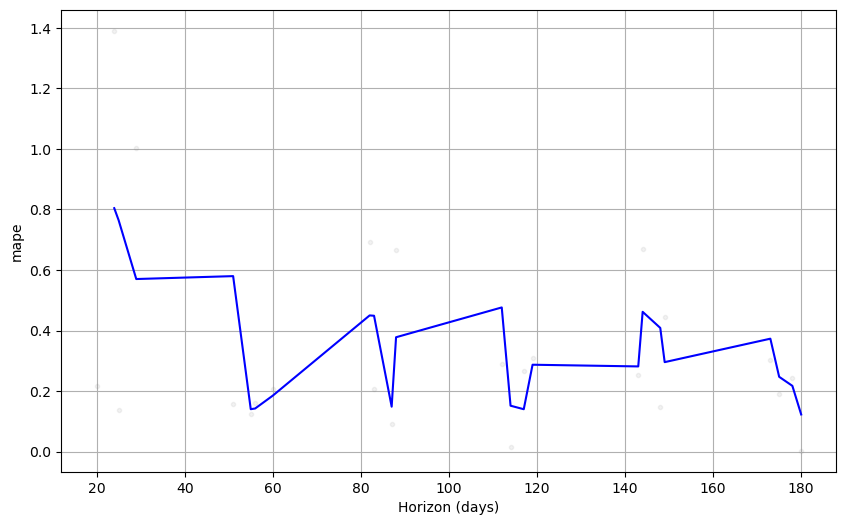

In [33]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [34]:
test_df

54     929333
55    1690948
56    1033615
57    1690948
58    1067615
59    1724948
Name: y, dtype: int64

In [35]:
pred

54    9.004149e+05
55    1.732672e+06
56    1.268215e+06
57    1.581823e+06
58    1.612990e+06
59    1.222684e+06
Name: yhat, dtype: float64

# FORECASTING

In [36]:
model_forecast = Prophet(changepoint_prior_scale=0.200, seasonality_prior_scale=10.00, seasonality_mode = 'additive',
                interval_width=0.95)

In [37]:
model_forecast.fit(sales_b)

16:49:43 - cmdstanpy - INFO - Chain [1] start processing
16:49:44 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=6, freq='MS')  # 6 months in 2024

In [39]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [40]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [41]:
forecasted_f_df

ds          yhat    yhat_lower    yhat_upper
60 2024-01-01  9.279057e+05  4.977796e+05  1.379891e+06
61 2024-02-01  1.700047e+06  1.228243e+06  2.117756e+06
62 2024-03-01  1.511746e+06  1.050714e+06  1.949264e+06
63 2024-04-01  1.310895e+06  8.605836e+05  1.762389e+06
64 2024-05-01  1.612125e+06  1.160269e+06  2.057822e+06
65 2024-06-01  9.228122e+05  4.984312e+05  1.354134e+06

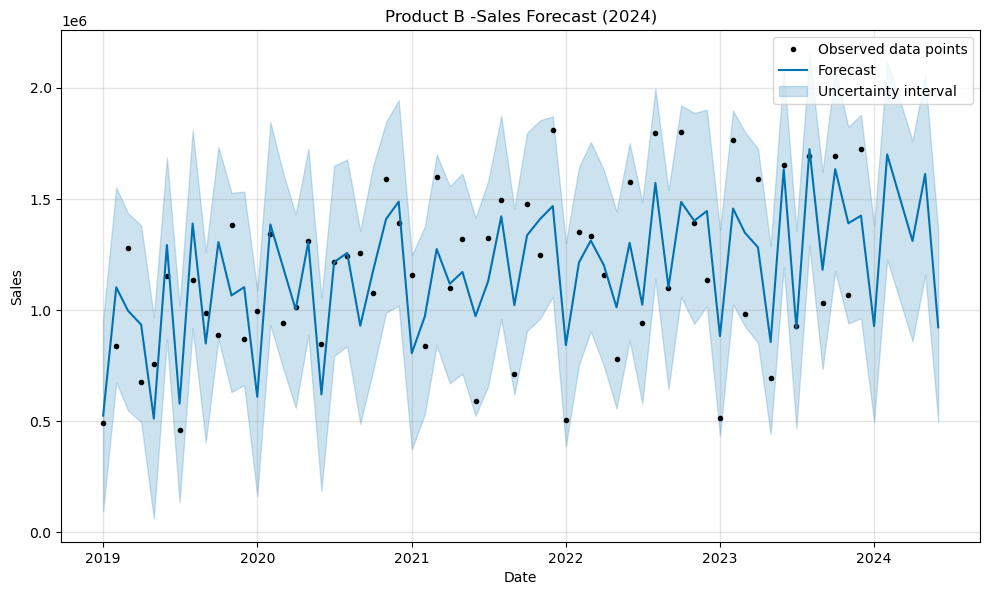

In [42]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [43]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [44]:
plot_components_plotly(model_forecast, forecast_f)